In [51]:
# ! pip install catboost

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import copy

#시각화
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

##알고리즘 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.utils import to_categorical

In [4]:
import matplotlib # 글자 깨짐 방지 폰트설정
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

## 데이터

## 데이터 불러오기

In [110]:
df_0 = pd.read_csv("d:/공모전/IPO/IPO/CleanData/X_train_Before_IPO.csv")
df = df_0.drop(['공모가 대비 3개월 수익률','공모가 대비 6개월 수익률'],axis =1)

In [111]:
def Cut(Series , cuts):
    "구분할 iter가능한 변수와 구분 기준을 입력받으면 구분 기준 앞에서 부터 1로 구분해서 return 함"
    Cuts = copy.deepcopy(cuts)
    Cuts.append(np.inf)
    Cuts.insert(0,-1*np.inf)
    R = len(Cuts)
    label = range(1,R)
    return pd.cut(Series, Cuts, labels = label)

In [112]:
## 기본 전처리
df['상장일'] = pd.to_datetime(df['상장일'])
df = df.set_index(['상장일'])
df = df.drop(['종목명','공모 시가총액'],axis = 1) ## 나중에 카테고리 진행할려면 남겨줄 것
df['Cat'] = Cut(df['공모가 대비 1개월 수익률'],[-0.2, -0.1, 0.1, 0.2])



In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 622 entries, 2009-04-07 to 2021-03-24
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   매출총이익률             622 non-null    float64 
 1   유동비율               622 non-null    float64 
 2   부채비율               622 non-null    float64 
 3   매출액증가율             622 non-null    float64 
 4   IPO_PER            622 non-null    float64 
 5   IPO_PBR            622 non-null    float64 
 6   IPO_EV/EBITDA      622 non-null    float64 
 7   1년전 대비 시장 회전율      622 non-null    float64 
 8   1년 전 대비 시장수익률      622 non-null    float64 
 9   1년 전 대비 고객예탁금 증감률  622 non-null    float64 
 10  상장일 기준 국고3년시장금리    622 non-null    float64 
 11  공모가 대비 1개월 수익률     622 non-null    float64 
 12  Cat                622 non-null    category
dtypes: category(1), float64(12)
memory usage: 63.9 KB


In [114]:
X = df.drop(["공모가 대비 1개월 수익률","Cat"],axis=1)
y = df['Cat']

<AxesSubplot:>

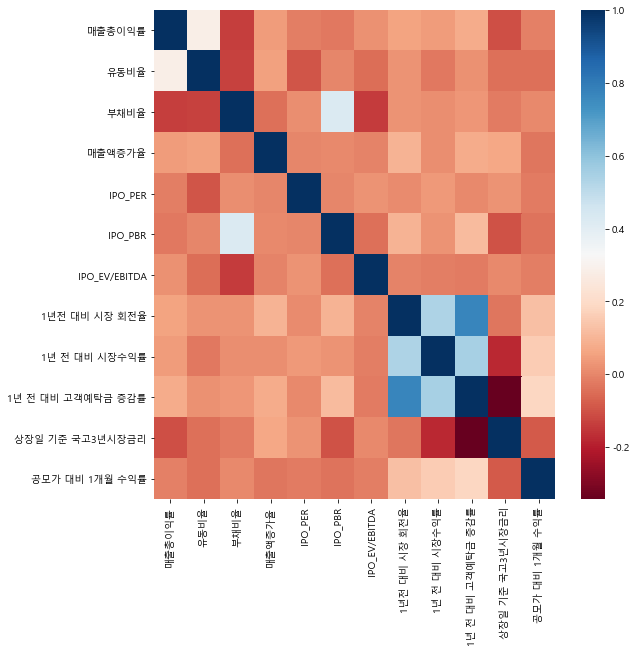

In [115]:
plt.figure(figsize =(9,9))
corr = df.corr()
sns.heatmap(corr,cmap='RdBu')

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.2,random_state=0)

In [146]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)

# 모델링

## 랜덤포레스트

In [186]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
print("----랜덤포레스트 분류 모델 평가----")
get_clf_eval(y_test,pred)

----랜덤포레스트 분류 모델 평가----
Confusion Matrix
[[ 0  0  3  0 11]
 [ 0  0  2  0  9]
 [ 4  1 15  0 16]
 [ 0  0  0  1 10]
 [ 0  2  7  2 42]]
정획도(accuracy): 0.4640, 정밀도(precision): 0.3917, 재현율(recall): 0.4640, f1_score: 0.4023


### 하이퍼파라미터 튜닝

In [187]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [400] ,
    'max_depth' : [2,4,5,8], 
    'min_samples_leaf' : [1,2,3,4, 8, 12 ,16],
    'min_samples_split' : [1,2,3,4, 8, 16,20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=5, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}
최고 예측 정확도: 0.4265


### 튜닝된 파라미터로 재실행

In [242]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf_2 = RandomForestClassifier(random_state=0 , max_depth = 5, min_samples_leaf = 3 , min_samples_split =  2 , n_estimators = 1000)
rf_clf_2.fit(X_train , y_train)
pred = rf_clf_2.predict(X_test)
print("----랜덤포레스트 분류 모델 평가----")
get_clf_eval(y_test,pred)

----랜덤포레스트 분류 모델 평가----
Confusion Matrix
[[ 0  0  1  0 13]
 [ 0  0  0  0 11]
 [ 0  0  9  0 27]
 [ 0  0  0  0 11]
 [ 0  0  3  0 50]]
정획도(accuracy): 0.4720, 정밀도(precision): 0.3887, 재현율(recall): 0.4720, f1_score: 0.3628


## 아무것도 안하고 돌렸을때
1. 정획도(accuracy): 0.5581, 정밀도(precision): 0.5581, 재현율(recall): 0.5581, f1_score: 0.5581 

## SMOTE하고 돌렸을때

### feature importance 시각화

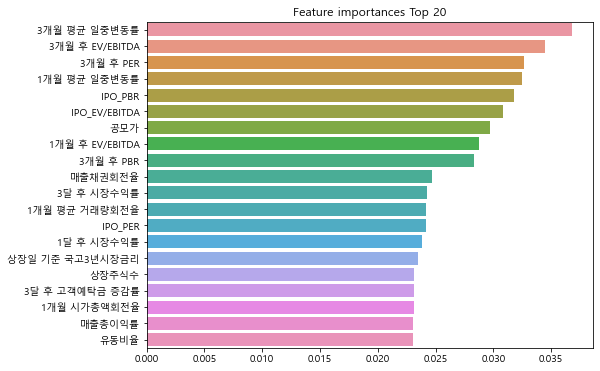

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### feature importance 값

In [199]:
ftr_importances.sort_values(ascending = False)

3개월 평균 일중변동률         0.036794
3개월 후 EV/EBITDA      0.034495
3개월 후 PER            0.032654
1개월 평균 일중변동률         0.032453
IPO_PBR              0.031825
IPO_EV/EBITDA        0.030855
공모가                  0.029708
1개월 후 EV/EBITDA      0.028786
3개월 후 PBR            0.028329
매출채권회전율              0.024720
3달 후 시장수익률           0.024272
1개월 평균 거래량회전율        0.024185
IPO_PER              0.024143
1달 후 시장수익률           0.023866
상장일 기준 국고3년시장금리      0.023458
상장주식수                0.023164
3달 후 고객예탁금 증감률       0.023093
1개월 시가총액회전율          0.023092
매출총이익률               0.023068
유동비율                 0.023035
1개월 후 PBR            0.022702
1개월 후 PER            0.022473
1년전 대비 시장 회전율        0.022392
매출액증가율               0.022154
3개월 평균 거래량회전율        0.021970
1달 후 고객예탁금 증감률       0.021473
3개월 평균 개인 매도수량 비중    0.021345
영업이익증가율              0.020928
1년 전 대비 시장수익률        0.020293
1달 후 광의통화 증감률        0.020262
당좌비율                 0.019883
3개월 시가총액회전율          0.019784
부채비율                 0.019634
ROE       

## XGBoost

In [197]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0)
xgb_wrapper.fit(X_train, y_train)

# predict  추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[18:16:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
Confusion Matrix
[[ 3  1  4  0  6]
 [ 1  0  3  0  7]
 [ 1  2 13  0 20]
 [ 1  0  1  0  9]
 [ 0  4  7  0 42]]
정획도(accuracy): 0.4640, 정밀도(precision): 0.4017, 재현율(recall): 0.4640, f1_score: 0.4106


### 하이퍼 파라미터 튜닝

In [191]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [192]:
# Init classifier
xgb_cl = XGBClassifier(objective="multi:softprob")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5, scoring="accuracy")

# Fit
grid_cv.fit(X_train, y_train)

[18:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None

In [194]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 0, 'subsample': 0.8}
최고 예측 정확도: 0.4365


### 튜닝된 파라미터로 재실행

In [196]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0,colsample_bytree = 0.5, gamma =  0,\
                            learning_rate =  0.1, max_depth =  3, reg_lambda =  0, subsample =  0.8 )
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[18:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
Confusion Matrix
[[ 2  0  5  0  7]
 [ 1  0  3  0  7]
 [ 3  1 11  0 21]
 [ 1  0  1  1  8]
 [ 1  2  8  1 41]]
정획도(accuracy): 0.4400, 정밀도(precision): 0.3921, 재현율(recall): 0.4400, f1_score: 0.3867


### 하이퍼 파라미터 변화 후

In [207]:
# Insert the new fixed values to the grid
param_grid["subsample"] = (0.6,1.0)
param_grid["colsample_bytree"] = (0.5,1.0)

# Give new value ranges to other params
param_grid["gamma"] = (0.01,0.25)
param_grid["max_depth"] = (2,10)
param_grid["reg_lambda"] = (0,10)
param_grid["learning_rate"] = (0.01,0.3, 0.5)

In [208]:
grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=5, scoring="accuracy", n_jobs=-1)

grid_cv_2.fit(X_train, y_train)

grid_cv_2.best_score_

[18:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.42856565656565654

In [209]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.01,
 'learning_rate': 0.01,
 'max_depth': 2,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 1.0}

### 튜닝된 파라미터로 재실행

In [219]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0,colsample_bytree = 1, gamma =  0.01,\
                            learning_rate =  0.01, max_depth =  4, reg_lambda =  0, subsample =  1)
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[18:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
Confusion Matrix
[[ 0  0  5  0  9]
 [ 1  0  1  1  8]
 [ 1  2  8  1 24]
 [ 0  0  1  1  9]
 [ 0  0  2  1 50]]
정획도(accuracy): 0.4720, 정밀도(precision): 0.3695, 재현율(recall): 0.4720, f1_score: 0.3758


### feature importance 시각화

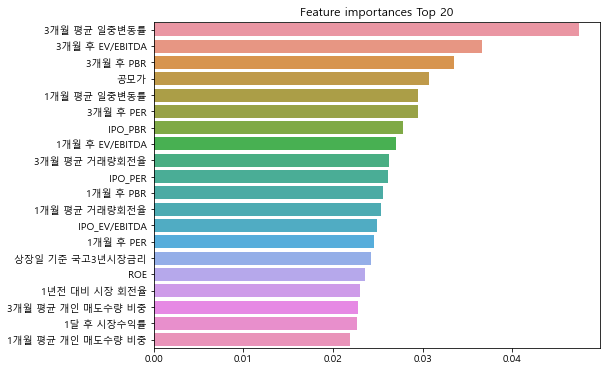

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### feature importance 값

In [212]:
ftr_importances.sort_values(ascending=False)

3개월 평균 일중변동률         0.047444
3개월 후 EV/EBITDA      0.036677
3개월 후 PBR            0.033514
공모가                  0.030720
1개월 평균 일중변동률         0.029529
3개월 후 PER            0.029476
IPO_PBR              0.027818
1개월 후 EV/EBITDA      0.027040
3개월 평균 거래량회전율        0.026295
IPO_PER              0.026128
1개월 후 PBR            0.025601
1개월 평균 거래량회전율        0.025353
IPO_EV/EBITDA        0.024903
1개월 후 PER            0.024533
상장일 기준 국고3년시장금리      0.024250
ROE                  0.023579
1년전 대비 시장 회전율        0.023069
3개월 평균 개인 매도수량 비중    0.022753
1달 후 시장수익률           0.022668
1개월 평균 개인 매도수량 비중    0.021913
매출총이익률               0.021800
유동비율                 0.021497
3달 후 광의통화 증감률        0.021414
1년 전 대비 고객예탁금 증감률    0.021334
3달 후 시장수익률           0.021105
3달 후 고객예탁금 증감률       0.021049
1달 후 광의통화 증감률        0.020935
매출액증가율               0.020899
3개월 시가총액회전율          0.020742
1달 후 고객예탁금 증감률       0.020441
3달 후 시장 회전율          0.020271
영업이익률                0.019988
3개월 평균 개인 매수수량 비중    0.019711
당좌비율      

## LGBM

In [213]:
# LGBM 분류기 객체 생성
lgbm_wrapper = LGBMClassifier(random_state = 0)

# 조기 중단 기능에 필요한 파라미터 정의
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)


# predict, predict_proba 추출
pred = lgbm_wrapper.predict(X_test)
print("----LGBM 분류 모델 평가----")
get_clf_eval(y_test,pred)

[1]	valid_0's multi_logloss: 1.38893
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.3504
[3]	valid_0's multi_logloss: 1.31655
[4]	valid_0's multi_logloss: 1.29155
[5]	valid_0's multi_logloss: 1.2686
[6]	valid_0's multi_logloss: 1.2559
[7]	valid_0's multi_logloss: 1.24325
[8]	valid_0's multi_logloss: 1.24285
[9]	valid_0's multi_logloss: 1.23854
[10]	valid_0's multi_logloss: 1.23683
[11]	valid_0's multi_logloss: 1.23067
[12]	valid_0's multi_logloss: 1.22685
[13]	valid_0's multi_logloss: 1.22037
[14]	valid_0's multi_logloss: 1.2232
[15]	valid_0's multi_logloss: 1.22941
[16]	valid_0's multi_logloss: 1.23067
[17]	valid_0's multi_logloss: 1.23043
[18]	valid_0's multi_logloss: 1.2383
[19]	valid_0's multi_logloss: 1.24617
[20]	valid_0's multi_logloss: 1.25246
[21]	valid_0's multi_logloss: 1.25426
[22]	valid_0's multi_logloss: 1.2679
[23]	valid_0's multi_logloss: 1.26504
[24]	valid_0's multi_logloss: 1.27121
[25]	valid_0's multi_logloss: 1.27731
[26

### 하이퍼 파라미터 튜닝

In [219]:
param_grid = {
    'num_leaves': [31, 127,400],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

In [220]:
lgbm_wrapper = LGBMClassifier(boosting_type='gbdt' , objective ="multi:softprob", num_boost_round=2000, learning_rate=0.01)

grid_cv = GridSearchCV(lgbm_wrapper, param_grid, n_jobs=-1, cv=3, scoring="accuracy")

# Fit
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(learning_rate=0.01, num_boost_round=2000,
                                      objective='multi:softprob'),
             n_jobs=-1,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [31, 127, 400],
                         'reg_alpha': [0.1, 0.5]},
             scoring='accuracy')

In [221]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'lambda_l1': 0, 'lambda_l2': 1, 'min_data_in_leaf': 50, 'num_leaves': 31, 'reg_alpha': 0.1}
최고 예측 정확도: 0.4932


### 튜닝된 파라미터로 재실행

In [222]:
# 모델 학습
lgbm_wrapper = LGBMClassifier(random_state = 0,lamnda_l1 = 0 , lamda_l2 = 1, min_data_in_leaf = 50 , num_leaves = 31, reg_alpha = 0.1)
lgbm_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = lgbm_wrapper.predict(X_test)
print("----lgbm  분류 모델 평가----")
get_clf_eval(y_test,pred)

----lgbm  분류 모델 평가----
Confusion Matrix
[[ 4  4  1  1  1]
 [ 3  6  2  4  2]
 [ 1  6  2  1  9]
 [ 0  3  3  7 11]
 [ 1  2  4  5 46]]
정획도(accuracy): 0.5039, 정밀도(precision): 0.5039, 재현율(recall): 0.5039, f1_score: 0.5039


### ???!!!

### feature importance 시각화

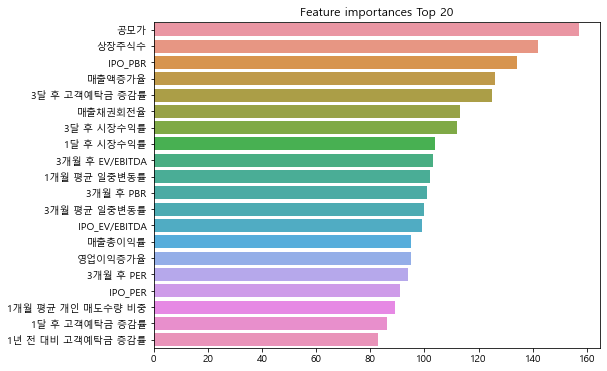

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### feature_importance 값

In [224]:
ftr_importances.sort_values(ascending=False)

공모가                  157
상장주식수                142
IPO_PBR              134
매출액증가율               126
3달 후 고객예탁금 증감률       125
매출채권회전율              113
3달 후 시장수익률           112
1달 후 시장수익률           104
3개월 후 EV/EBITDA      103
1개월 평균 일중변동률         102
3개월 후 PBR            101
3개월 평균 일중변동률         100
IPO_EV/EBITDA         99
매출총이익률                95
영업이익증가율               95
3개월 후 PER             94
IPO_PER               91
1개월 평균 개인 매도수량 비중     89
1달 후 고객예탁금 증감률        86
1년 전 대비 고객예탁금 증감률     83
1개월 후 PBR             79
상장일 기준 국고3년시장금리       79
3개월 평균 개인 매도수량 비중     78
ROE                   78
유동비율                  77
3달 후 광의통화 증감률         75
1년전 대비 시장 회전율         74
1년 전 대비 시장수익률         73
당좌비율                  73
부채비율                  65
1개월 평균 거래량회전율         63
3개월 평균 개인 매수수량 비중     62
1개월 후 EV/EBITDA       52
1년 전 대비 광의통화 증감률      52
1달 후 광의통화 증감률         49
1개월 평균 개인 매수수량 비중     48
1개월 후 PER             47
3개월 평균 거래량회전율         44
1달 후 시장 회전율           40
3개월 시가총액회전율           37
